# Speaker Recognition using Neural Networks

Welcome to this project notebook on **Speaker Recognition using Neural Networks**.

---

## **Task Overview**

The main objective of this notebook is to build an end-to-end speaker identification system using deep learning. Speaker identification is the process of determining which registered speaker is talking from a set of known speakers, based solely on their voice. Unlike speaker verification (which checks if a claimed identity is correct), identification must select the correct speaker from multiple candidates.

---

## **Project Objectives**

- **Data Preparation:** Load and preprocess audio samples from multiple speakers, and augment the dataset with background noise to improve model robustness to real-world conditions.
- **Feature Extraction:** Convert raw audio waveforms to frequency-domain features using Fast Fourier Transform (FFT), capturing speaker-specific vocal characteristics.
- **Modeling:** Design and train a Convolutional Neural Network (CNN) with residual connections to classify speakers based on their voice features.
- **Interactive Experimentation:** Provide tools to systematically explore and tune model hyperparameters (such as number of layers, filters, and activation functions) using interactive widgets.
- **Evaluation & Visualization:** Assess model performance using validation accuracy, and visualize the learned feature space with t-SNE plots to interpret how well the model separates different speakers.



## Motivation

I chose the topic of speaker recognition because of its real-world relevance in security, personalized assistants, and human-computer interaction. The challenge of distinguishing speakers based on their voice-despite background noise, emotional variation, and recording differences-makes it a compelling machine learning problem. I was particularly interested in exploring how deep learning models can extract and leverage subtle vocal features that are unique to each individual.


### Implementation Overview

The image below shows the complete workflow of the speaker identification system:

1. **Sound Signal** – Raw input audio.
2. **Augmented Signal** – Noise is added to simulate real-world scenarios.
3. **FFT Spectrogram** – Signal is converted into a frequency domain using FFT.
4. **Neural Network Model** – A CNN is trained on the spectrograms.
5. **Output** – The model identifies the speaker.


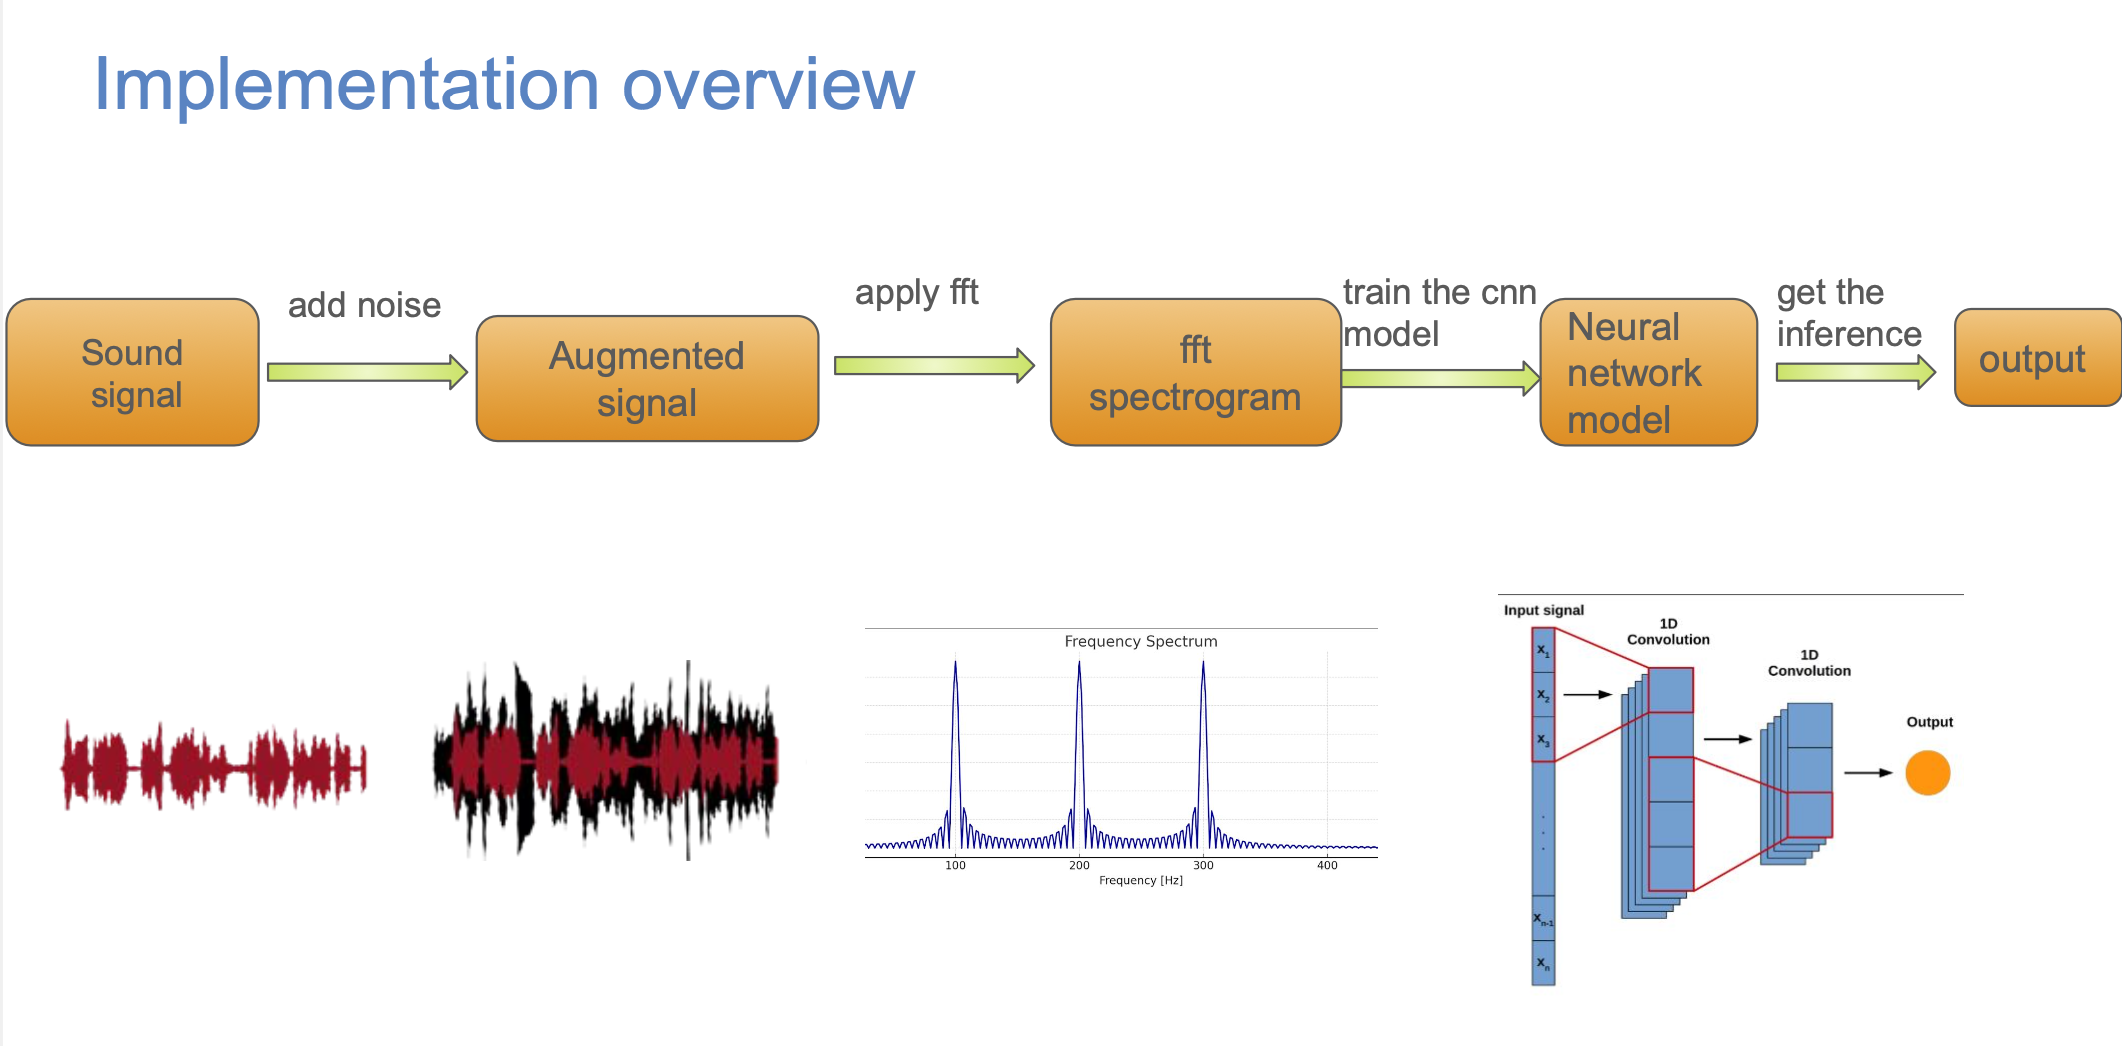




**Let's get started by setting up the environment and exploring the dataset!**


### Imports and Packages to Download

In [1]:
!apt-get update && apt-get install -y ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]                 
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,665 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]                 
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.ill

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import shutil
import numpy as np
import tensorflow as tf
import keras
from pathlib import Path
from IPython.display import display, Audio, clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tensorflow import keras

2025-05-08 20:46:59.060949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746737219.299771      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746737219.373334      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### util function to copy files from one directory to other 

In [3]:
def safe_copy(src, dst):
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

### Config 

In [4]:
## root folders
DATASET_ROOT = "/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches"
NEW_DATASET_ROOT="/kaggle/working/16000_pcm_speeches"

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(NEW_DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(NEW_DATASET_ROOT, NOISE_SUBFOLDER)
os.makedirs(DATASET_AUDIO_PATH, exist_ok=True)
os.makedirs(DATASET_NOISE_PATH, exist_ok=True)
# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all the audio samples.
# We will resample all the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 1

In [5]:
print("The speakers in dataset: ")
for x in os.listdir(DATASET_ROOT):
    print(x)

The speakers in dataset: 
Nelson_Mandela
Benjamin_Netanyau
other
_background_noise_
tf_Wav_reader.py
Magaret_Tarcher
Jens_Stoltenberg
Julia_Gillard


### copy files from read folder to working folder to work on them

In [6]:
for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            safe_copy(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            safe_copy(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )
        print(f"done copying folder: {folder}")

done copying folder: Nelson_Mandela
done copying folder: Benjamin_Netanyau
done copying folder: other
done copying folder: _background_noise_
done copying folder: Magaret_Tarcher
done copying folder: Jens_Stoltenberg
done copying folder: Julia_Gillard


In [7]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]
if not noise_paths:
    raise RuntimeError(f"Could not find any files at {DATASET_NOISE_PATH}")
print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)


Found 6 files belonging to 2 directories


In [8]:
noise_paths

['/kaggle/working/16000_pcm_speeches/noise/_background_noise_/10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 '/kaggle/working/16000_pcm_speeches/noise/_background_noise_/doing_the_dishes.wav',
 '/kaggle/working/16000_pcm_speeches/noise/_background_noise_/running_tap.wav',
 '/kaggle/working/16000_pcm_speeches/noise/_background_noise_/dude_miaowing.wav',
 '/kaggle/working/16000_pcm_speeches/noise/other/pink_noise.wav',
 '/kaggle/working/16000_pcm_speeches/noise/other/exercise_bike.wav']

#### check the refresh rate for the noise samples conver if not 16000 then convert into 16000 and make them 1sec chunks

In [9]:

command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)


# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

I0000 00:00:1746737307.430760      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746737307.431402      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


6 noise files were split into 354 noise samples where each is 1 sec. long


### Audio Preprocessing Functions

- `path_to_audio(path)`: Loads and decodes a WAV audio file into a waveform tensor using a fixed sampling rate.

- `paths_and_labels_to_dataset(audio_paths, labels)`: Creates a TensorFlow dataset of (audio, label) pairs by mapping audio file paths_


In [10]:

def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


- `add_noise(audio, noises=None, scale=0.5)`: Adds randomly selected and amplitude-matched background noise to an audio tensor to augment training data.


### Data Augmentation

The image below illustrates the data augmentation process used in the speaker recognition system. To make the model more robust, random noise is scaled and added to the original audio signal. This helps simulate real-world conditions and improves the model’s ability to generalize.



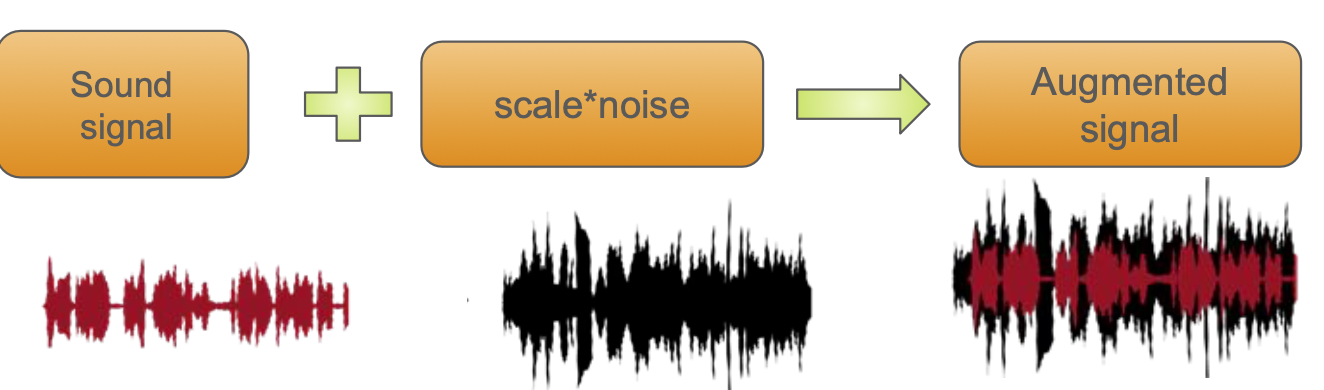


In [11]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


## FFT



The Fast Fourier Transform (FFT) is a powerful tool for analyzing the frequency content of signals, especially sound signals. The image above illustrates the step-by-step process of converting a raw sound signal into its frequency components using FFT:

1. **Sound signal**: This is the original time-domain representation of the sound. It contains information about how the signal varies over time but doesn't reveal frequency information directly.
2. **Windowed signal**: To analyze a portion of the sound signal, a window function (e.g., Hamming, Hann) is applied. This reduces spectral leakage by tapering the signal edges before transformation.
3. **FFT spectrogram**: The windowed signal is then passed through the FFT algorithm, converting it from the time domain to the frequency domain. This step produces both positive and negative frequency components.
4. **Positive frequencies**: Since real-valued signals produce symmetric FFT outputs, typically only the positive frequency half is retained for analysis and visualization.

This process is fundamental in digital signal processing and is widely used in applications like speech recognition, music analysis, and audio compression.


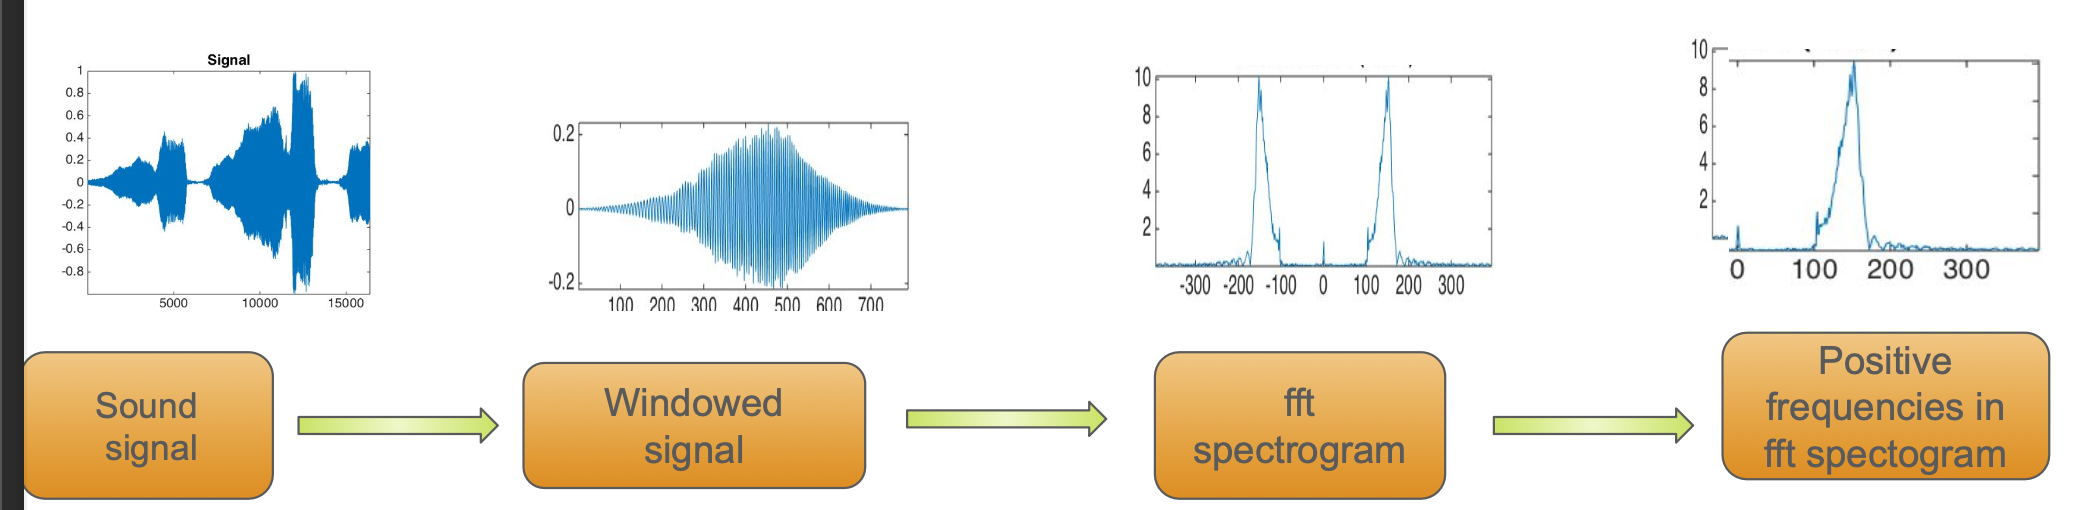


In [12]:
def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])



In [13]:

# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print(
    "Our class names: {}".format(
        class_names,
    )
)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print(
        "Processing speaker {}".format(
            name,
        )
    )
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)


Our class names: ['Nelson_Mandela', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Julia_Gillard']
Processing speaker Nelson_Mandela
Processing speaker Jens_Stoltenberg
Processing speaker Magaret_Tarcher
Processing speaker Benjamin_Netanyau
Processing speaker Julia_Gillard
Found 7501 files belonging to 5 classes.


#### preparing training and validation splits

In [14]:
# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, on

Using 6751 files for training.
Using 750 files for validation.


#### preparing datasets for the model 

In [15]:


# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)




### Model training here i used a general CNN architecture 

### CNN Model Architecture

The figure below shows the CNN architecture used for speaker identification, including convolutional layers with residual connections, activation functions, pooling layers, and dense layers for classification.



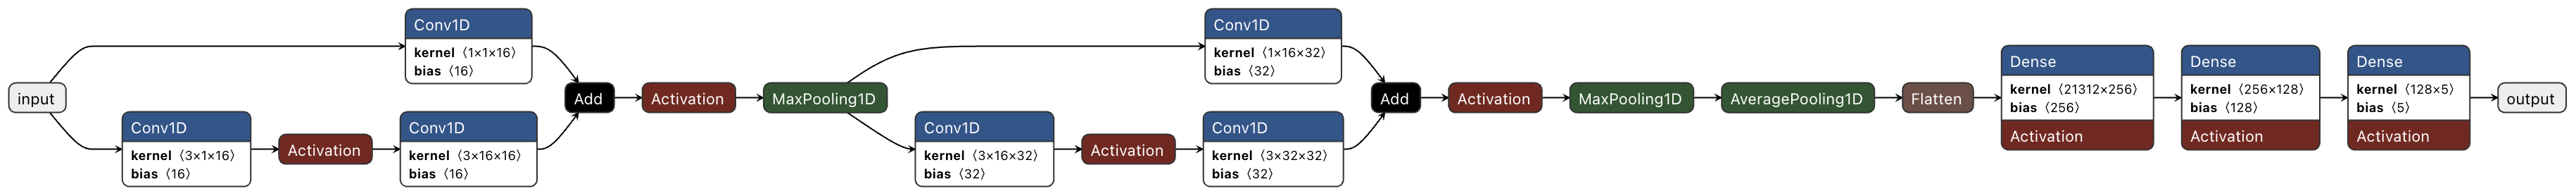


In [16]:
# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

In [17]:

def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for _ in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

def build_model(input_shape, num_classes, filters_list, conv_num_list, activation="relu"):
    inputs = keras.layers.Input(shape=input_shape, name="input")
    x = inputs
    for filters, conv_num in zip(filters_list, conv_num_list):
        x = residual_block(x, filters, conv_num, activation)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)
    return keras.models.Model(inputs=inputs, outputs=outputs)





### CNN Model Architecture

The figure below shows the CNN architecture used for speaker identification, including convolutional layers with residual connections, activation functions, pooling layers, and dense layers for classification.



In [18]:
# Constants
filter_values = [16, 32, 64, 128, 256]
conv_num_values = [1, 2, 3, 4, 5]

# Number of blocks slider
num_blocks_slider = widgets.IntSlider(value=5, min=1, max=6, step=1, description="Blocks:")

# Activation function selector
activation_dropdown = widgets.Dropdown(
    options=["relu", "tanh", "swish"], value="relu", description="Activation:"
)

# Filter sliders (with Dropdown values)
filters_sliders = [
    widgets.SelectionSlider(options=filter_values, value=val, description=f"Filters {i+1}")
    for i, val in enumerate([16, 32, 64, 128, 128, 128])
]

# Conv Num sliders (Dropdown values)
convnum_sliders = [
    widgets.SelectionSlider(options=conv_num_values, value=val, description=f"Conv {i+1}")
    for i, val in enumerate([2, 2, 3, 3, 3, 3])
]

parameter_dropdown = widgets.Dropdown(
    options=["Blocks"] + [f'Filters {i+1}' for i in range(6)] + [f'Conv {i+1}' for i in range(6)],
    value='Filters 1',
    description='Vary Parameter:',
)


### 🔍 `run_parameter_sweep` Function — Overview

1. **Purpose**:
   This function performs a parameter sweep on a CNN model to analyze how changing one architectural parameter (e.g., number of blocks, filters, or convolution layers) impacts validation accuracy.

2. **Supported Parameters**:
   You can vary:

   * Number of residual blocks (`Blocks`)
   * Number of filters in any block (`Filters 1` to `Filters 6`)
   * Number of convolutions in any block (`Conv 1` to `Conv 6`)

3. **How It Works**:
   For the selected parameter, the model is rebuilt and trained across a range of values while keeping others constant. It uses early stopping and evaluates on a validation set.

4. **Outputs**:
   The function prints validation accuracy for each configuration and plots a line graph showing how accuracy changes with the selected parameter.

5. **Interactive Integration**:
   Integrated with `ipywidgets.interact`, allowing dynamic exploration directly in a Jupyter notebook with sliders and dropdowns.




In [19]:
def run_parameter_sweep(blocks, activation, parameter_to_vary, **kwargs):
    clear_output(wait=True)
    print(f"🧪 Running sweep: {parameter_to_vary}")

    # Get base values
    filters_list = [kwargs[f"Filters {i+1}"] for i in range(6)]
    conv_num_list = [kwargs[f"Conv {i+1}"] for i in range(6)]

    accuracies = []
    
    if parameter_to_vary == "Blocks":
        values = list(range(1, 7))  # from 1 to 6 blocks
        for val in values:
            model = build_model(
                input_shape=(SAMPLING_RATE // 2, 1),
                num_classes=len(class_names),
                filters_list=filters_list[:val],
                conv_num_list=conv_num_list[:val],
                activation=activation,
            )

            model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
            model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[earlystopping_cb], verbose=0)
            _, acc = model.evaluate(valid_ds, verbose=0)
            print(f"Blocks = {val} ➜ Val Accuracy: {acc:.4f}")
            accuracies.append(acc)
            
    else:
        # Existing behavior for Filters or Conv
        is_filter = parameter_to_vary.startswith("Filters")
        index = int(parameter_to_vary.split()[1]) - 1
        values = filter_values if is_filter else conv_num_values

        for val in values:
            f_list = filters_list[:blocks]
            c_list = conv_num_list[:blocks]
            if is_filter:
                f_list[index] = val
            else:
                c_list[index] = val

            model = build_model(
                input_shape=(SAMPLING_RATE // 2, 1),
                num_classes=len(class_names),
                filters_list=f_list,
                conv_num_list=c_list,
                activation=activation,
            )

            model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
            model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[earlystopping_cb], verbose=0)
            _, acc = model.evaluate(valid_ds, verbose=0)
            print(f"{parameter_to_vary} = {val} ➜ Val Accuracy: {acc:.4f}")
            accuracies.append(acc)
           
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(values, accuracies, marker='o')
    plt.title(f"Accuracy vs. {parameter_to_vary}")
    plt.xlabel(parameter_to_vary)
    plt.ylabel("Validation Accuracy")
    plt.grid(True)
    plt.show()
    


controls = [num_blocks_slider, activation_dropdown, parameter_dropdown] + filters_sliders + convnum_sliders
widgets.interact(run_parameter_sweep,
                 blocks=num_blocks_slider,
                 activation=activation_dropdown,
                 parameter_to_vary=parameter_dropdown,
                 **{s.description: s for s in filters_sliders + convnum_sliders});

interactive(children=(IntSlider(value=5, description='Blocks:', max=6, min=1), Dropdown(description='Activatio…

In [20]:
f_list=[16, 32, 64, 128, 128, 128]
c_list=[2, 2, 3, 3, 3, 3]
num_blocks=2
activation="relu"
model = build_model(
                input_shape=(SAMPLING_RATE // 2, 1),
                num_classes=len(class_names),
                filters_list=f_list[:num_blocks],
                conv_num_list=c_list[:num_blocks],
                activation=activation,
            )

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[earlystopping_cb], verbose=0)
_, acc = model.evaluate(valid_ds, verbose=0)

print(f"Val Accuracy: {acc:.4f}")

Val Accuracy: 0.8413


In [21]:
# Prepare test dataset
test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(BATCH_SIZE)
test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y), num_parallel_calls=tf.data.AUTOTUNE)

### Testing inference

In [22]:
# Get a single batch
for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    
    audios_np = audios.numpy()
    labels_np = labels.numpy()
    y_pred_np = np.argmax(y_pred, axis=-1)

    def play_sample(index):
        clear_output(wait=True)
        audio_sample = audios_np[index, :, :].squeeze()
        label = labels_np[index]
        pred = y_pred_np[index]
        is_correct = label == pred

        print(f"\033[92mSpeaker: {class_names[label]}\033[0m" if is_correct else f"\033[91mSpeaker: {class_names[label]}\033[0m")
        print(f"\033[92mPredicted: {class_names[pred]}\033[0m" if is_correct else f"\033[91mPredicted: {class_names[pred]}\033[0m")
        display(Audio(audio_sample, rate=SAMPLING_RATE))

    # Create a slider widget
    slider = widgets.IntSlider(value=0, min=0, max=BATCH_SIZE - 1, step=1, description='Sample:')
    widgets.interact(play_sample, index=slider)
    break


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


interactive(children=(IntSlider(value=0, description='Sample:', max=127), Output()), _dom_classes=('widget-int…

### T-SNE plot
t-SNE (t-distributed Stochastic Neighbor Embedding) is a technique that helps us visualize high-dimensional data in just two dimensions, making it easier to understand. In this speaker recognition project, t-SNE is used to show how well the model can tell different speakers apart. It takes the complex features extracted from the audio signals (like the FFT spectrograms) and plots them in a 2D space. If the model is working well, we should see that the data points for each speaker form clear, separate clusters. This kind of plot helps us visually confirm that the model is learning to recognize the unique voice features of each speaker.


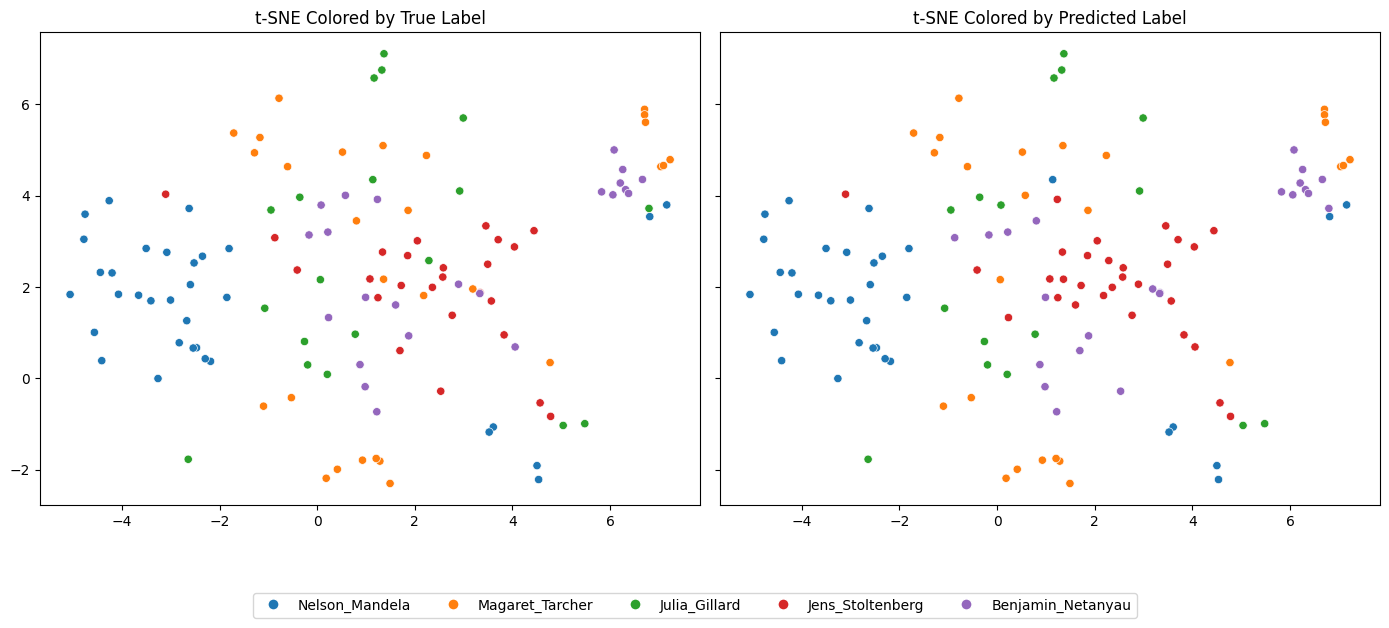

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the FFTs
ffts_np = ffts.numpy().reshape((ffts.shape[0], -1))

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(ffts_np)

# Prepare class labels
class_names_fixed = ['Nelson_Mandela', 'Magaret_Tarcher', 'Julia_Gillard', 'Jens_Stoltenberg', 'Benjamin_Netanyau']
true_labels = [class_names[i] for i in labels_np]
pred_labels = [class_names[i] for i in y_pred_np]

# Fixed color palette
palette = dict(zip(class_names_fixed, sns.color_palette("tab10", n_colors=len(class_names_fixed))))

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# True label plot
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=true_labels,
    palette=palette,
    ax=axs[0],
    legend=False
)
axs[0].set_title("t-SNE Colored by True Label")

# Predicted label plot
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=pred_labels,
    palette=palette,
    ax=axs[1],
    legend=False
)
axs[1].set_title("t-SNE Colored by Predicted Label")

# Shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=cls,
                      markerfacecolor=palette[cls], markersize=8) for cls in class_names_fixed]
fig.legend(handles, class_names_fixed, loc='lower center', ncol=len(class_names_fixed), bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


In [24]:
model.save("speaker_identification_cnn_model.keras")

## Connection with Multimodal Learning: A Recent Historical Perspective

Speaker recognition has evolved rapidly in recent years. Early systems relied on handcrafted features like MFCCs and GMMs, but the field has shifted towards deep learning for more robust, end-to-end solutions. In the context of multimodal learning, modern research increasingly combines audio with other modalities-such as video (lip movement, facial cues) or text-to improve recognition accuracy in real-world scenarios. For example, architectures like VGGVox and various multimodal fusion networks have demonstrated that integrating visual information with audio can significantly boost performance, especially under noisy or unconstrained conditions. My work, while focused on audio, fits within this trend and could be extended to multimodal pipelines by adding visual features or other sensor data.


## Learning Outcomes

- **Data Augmentation:** I learned the importance of augmenting speech data with realistic background noise, which helps the model generalize better to real-world environments.
- **Feature Engineering:** Applying Fast Fourier Transform (FFT) to raw audio provided a powerful way to extract speaker-specific frequency features.
- **Model Design:** Building and tuning a CNN with residual blocks taught me about architectural choices that impact both convergence and accuracy.
- **Experimentation:** Using interactive widgets for parameter sweeps enabled efficient exploration of the hyperparameter space and gave me practical insights into model sensitivity.
- **Visualization:** t-SNE plots were invaluable for qualitatively assessing how well the neural network separates speakers in feature space.



## Reflections

**(a) What surprised me?**  
I was surprised by how much background noise augmentation improved model robustness. Also, the t-SNE visualizations revealed that even with relatively simple FFT features and a modest CNN, the model could form distinct clusters for each speaker.

**(b) Scope for improvement:**  
- Integrating visual modalities (e.g., lip reading) could further boost accuracy, especially in noisy conditions.
- Experimenting with more advanced audio features (like spectrograms or embeddings from pretrained models) and deeper architectures could yield better performance.
- Extending the system to open-set recognition or speaker verification would make it more practical for real-world
applications.


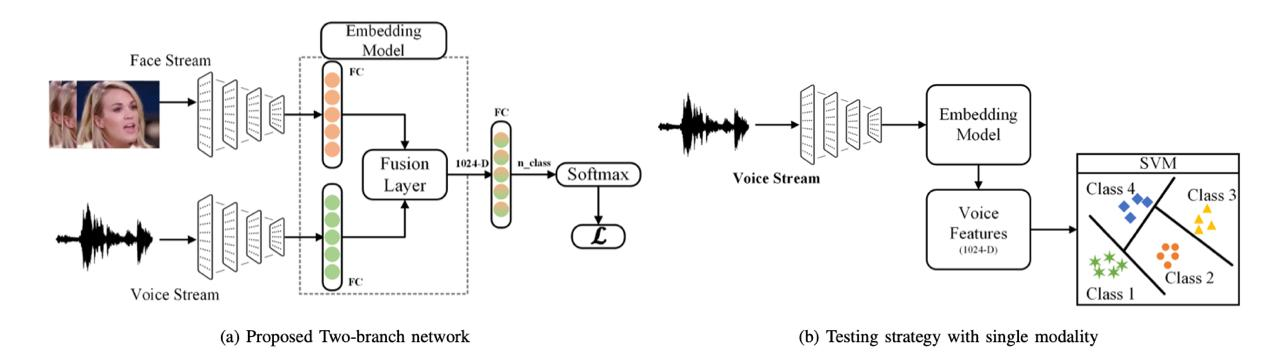


## Multimodal Connection

While this project focuses primarily on audio-based speaker recognition, it aligns closely with the growing field of multimodal learning. Modern speaker recognition systems increasingly incorporate additional modalities—such as visual cues from lip movements and facial expressions—to enhance identification accuracy.

Research such as "Speaker Recognition in Realistic Scenario Using Multimodal Data" highlights the benefits of combining facial and voice data. Similarly, the VGGVox model I referenced employs deep convolutional architectures akin to those used here, but extended to handle multiple input streams.

This project lays the groundwork for potential multimodal extensions. A natural next step would be to incorporate visual data alongside audio features using a two-branch neural network, where each modality is processed independently before their representations are fused. The T-SNE visualizations included in this project suggest that such multimodal integration could produce more distinct clustering, reflecting improved speaker discrimination.



### THANK YOU